## High res ecco - Melville Bay

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import glob
import cartopy
import cartopy.crs as ccrs

In [2]:
geometry = xr.open_dataset("SASSIE_N1_geometry_v3.nc")

In [21]:
geometry

<xarray.Dataset>
Dimensions:  (j: 1080, i: 1440, k: 90)
Coordinates:
    XC       (j, i) float32 ...
    YC       (j, i) float32 ...
    Z        (k) float32 0.5 1.57 2.79 4.185 ... 5.882e+03 6.301e+03 6.76e+03
    Zu       (k) float32 1.0 2.14 3.44 4.93 ... 6.082e+03 6.52e+03 7e+03
    Zl       (k) float32 0.0 1.0 2.14 3.44 ... 5.682e+03 6.082e+03 6.52e+03
Dimensions without coordinates: j, i, k
Data variables:
    hFacC    (k, j, i) float64 ...
    maskC    (k, j, i) int64 ...
    RAC      (j, i) float64 ...
    dX       (j, i) float64 ...
    drF      (k) float64 1.0 1.14 1.3 1.49 1.7 ... 334.6 365.9 400.4 438.2 479.7
Attributes:
    date_created:            2022-04-26T21:59:37
    date_modified:           2022-04-26T21:59:37
    date_metadata_modified:  2022-04-26T21:59:37
    date_issued:             2022-04-26T21:59:37

#### Create netCDFs for theta and salt

In [91]:
ecco_melville_theta_dir = Path('H:/PhD_chap3/data/ECCO_melville/W_Greenland/THETA/')
ecco_melville_salt_dir = Path('H:/PhD_chap3/data/ECCO_melville/W_Greenland/SALT/')

In [92]:
theta_files = list(ecco_melville_theta_dir.glob('*nc'))
salt_files = list(ecco_melville_salt_dir.glob('*nc'))

In [93]:
## theta
theta_ds = xr.open_mfdataset(theta_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [94]:
## salt
salt_ds = xr.open_mfdataset(salt_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

Need to make a coordinate that combines year, month, and day

In [95]:
def create_time_dt64(ecco_ds):
    time_list = []
    for i in range(len(ecco_ds.time.values)):
        year  = ecco_ds.years.isel(time=i).values
        month = ecco_ds.months.isel(time=i).values
        day   = ecco_ds.days.isel(time=i).values
        
        if month<10 and day<10:
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+'0'+str(day)
        elif month<10 and day>=10: 
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+str(day)
        elif month>=10 and day<10: 
            time_tmp = str(year)+'-'+str(month)+'-'+'0'+str(day)
        else:
            time_tmp = str(year)+'-'+str(month)+'-'+str(day)
        
        time_list.append(time_tmp)
    
    time_dt64 = np.array(time_list, dtype='datetime64')
        
    return time_dt64

In [96]:
time_dt64 = create_time_dt64(theta_ds)

Add new time coordinate to dataset

In [97]:
theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
salt_time_ds  = salt_ds.assign_coords({"time":time_dt64})

Pull out timestep to plot temp and salt

In [98]:
theta_400m = theta_time_ds.sel(time="2015-03").mean("time").sel(depth=400, method='nearest')
salt_400m  = salt_time_ds.sel(time="2015-03").mean("time").sel(depth=400, method='nearest')

theta_300m = theta_time_ds.sel(time="2015-03").mean("time").sel(depth=300, method='nearest')
salt_300m  = salt_time_ds.sel(time="2015-03").mean("time").sel(depth=300, method='nearest')

In [13]:
## make land mask
land_mask = salt_time_ds.isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).SALT.isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

Save subsets

In [35]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_400m.to_netcdf(output_dir + "theta_201503_400m.nc")
salt_400m.to_netcdf(output_dir + "salt_201503_400m.nc")
land_mask.to_netcdf(output_dir + "land_mask.nc")

Make subsets that include lat lon coordinates

In [99]:
theta_201503_400m = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=400, method='nearest').THETA.sel(time="2015-03")
salt_201503_400m  = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=400, method='nearest').SALT.sel(time="2015-03")

theta_201503_300m = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=300, method='nearest').THETA.sel(time="2015-03")
salt_201503_300m  = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=300, method='nearest').SALT.sel(time="2015-03")

In [26]:
theta_201503_400m.to_netcdf(output_dir + "theta_201503_400m_latlon.nc")
salt_201503_400m.to_netcdf(output_dir + "salt_201503_400m_latlon.nc")

In [15]:
salt_201503 = salt_time_ds.sel(time="2015-03-01").isel(depth=0)

In [16]:
## make land mask
land_mask = salt_time_ds.set_coords(['longitude','latitude']).isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

In [55]:
land_mask.to_netcdf(output_dir + "land_mask_latlon.nc")

#### Plot model domain

Open subsets

In [36]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_400m = xr.open_dataset(output_dir + "theta_201503_400m.nc")
salt_400m = xr.open_dataset(output_dir + "salt_201503_400m.nc")
land_mask = xr.open_dataset(output_dir + "land_mask.nc")

theta_201503_400m = xr.open_dataset(output_dir + "theta_201503_400m_latlon.nc")
salt_201503_400m = xr.open_dataset(output_dir + "salt_201503_400m_latlon.nc")
land_mask_latlon = xr.open_dataset(output_dir + "land_mask_latlon.nc")

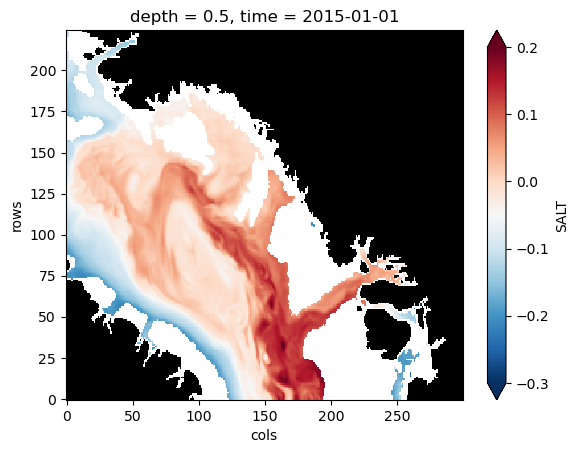

In [37]:
salt_400m_below = salt_400m.SALT.where(salt_400m.SALT>30,drop=True)
(salt_400m_below-salt_400m_below.mean()).plot(vmin=-0.3,vmax=0.2,cmap='RdBu_r')
land_mask.SALT.plot(add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

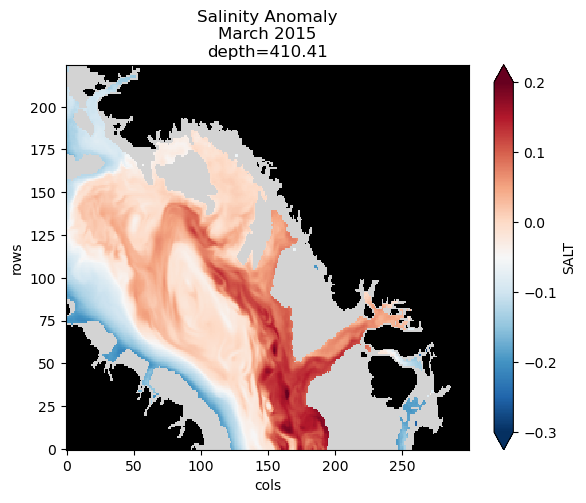

In [38]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

## salt below surface
salt_400m_below = salt_400m.SALT.where(salt_400m.SALT>30,drop=True)

(salt_400m_below-salt_400m_below.mean()).plot(ax=ax1,vmin=-0.3,vmax=0.2,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

ax1.set_title("Salinity Anomaly\nMarch 2015\ndepth=" + str(salt_400m.depth.values));

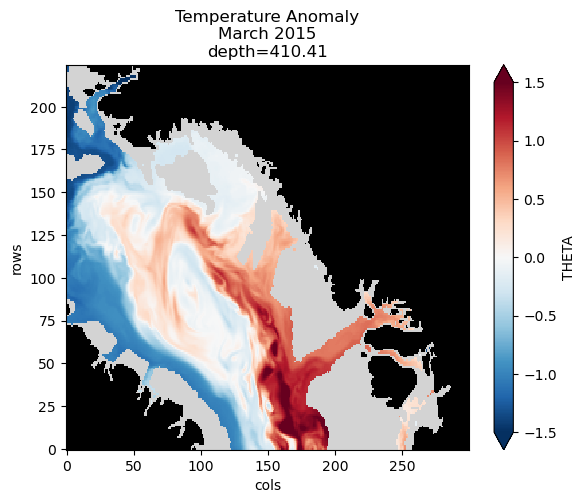

In [39]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

theta_400m_below = theta_400m.THETA.where(salt_400m.SALT>30,drop=True)

(theta_400m_below-theta_400m_below.mean()).plot(ax=ax1,vmin=-1.5,vmax=1.5,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

ax1.set_title("Temperature Anomaly\nMarch 2015\ndepth=" + str(theta_400m.depth.values));

#### Plot bathymetry over model domain

Load bathymetry data

In [100]:
gebco_bathy = xr.open_dataset("H:/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc")

In [101]:
gebco_bathy_select = gebco_bathy.sel(lon=slice(-75,-56),lat=slice(69,76)).elevation.load()

In [104]:
theta_201503_400m_ts0 = theta_201503_400m.isel(time=0)
salt_201503_400m_ts0 = salt_201503_400m.isel(time=0)
theta_400m_below = theta_201503_400m_ts0.where(salt_201503_400m_ts0>30,drop=True)
salt_400m_below = salt_201503_400m_ts0.where(salt_201503_400m_ts0>30,drop=True)

theta_201503_300m_ts0 = theta_201503_300m.isel(time=0)
salt_201503_300m_ts0 = salt_201503_300m.isel(time=0)
theta_300m_below = theta_201503_300m_ts0.where(salt_201503_300m_ts0>30,drop=True)
salt_300m_below = salt_201503_300m_ts0.where(salt_201503_300m_ts0>30,drop=True)

Plot lines for AW boxes over T and S with isobaths

In [75]:
salt_400m_coords = salt_400m.set_coords(['longitude','latitude'])

In [103]:
## subset lines that we extracted for AW boxes
salt_row000_AW_line = salt_400m_coords.isel(rows=0,  cols=slice(185,210))
salt_row025_AW_line = salt_400m_coords.isel(rows=25, cols=slice(160,200))
salt_row050_AW_line = salt_400m_coords.isel(rows=50, cols=slice(145,160))
salt_row075_AW_line = salt_400m_coords.isel(rows=75, cols=slice(155,170))
salt_row100_AW_line = salt_400m_coords.isel(rows=100,cols=slice(140,155))
salt_row125_AW_line = salt_400m_coords.isel(rows=125,cols=slice(95,105))
salt_row150_AW_line = salt_400m_coords.isel(rows=150,cols=slice(130,145))

In [77]:
salt_400m_below_anomaly = (salt_400m_below-salt_400m_below.mean()).load()

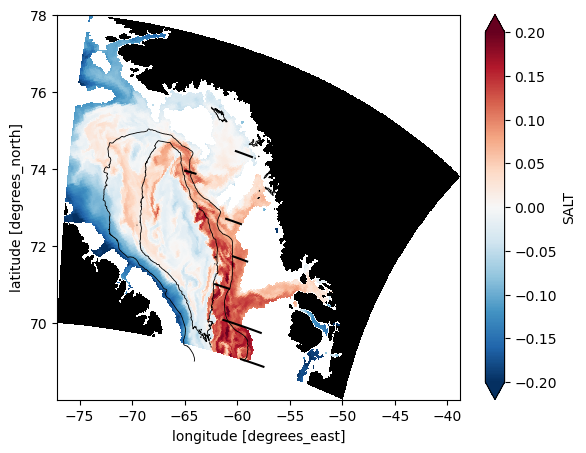

In [105]:
land_mask_latlon.SALT.plot(y='latitude',x='longitude',cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False)
# (salt_400m_coords.SALT.where(salt_400m_coords.SALT>30)).plot(x='longitude',y='latitude',vmin=33.5,vmax=34.6)
salt_400m_below_anomaly.plot(x='longitude',y='latitude',vmin=-0.2,vmax=0.2,cmap='RdBu_r')
gebco_bathy_select.plot.contour(levels=[-2000,-1000],\
                                linestyles='solid',linewidths=0.6,colors='k');

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k')
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k')
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k')
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k')
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k')
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k')
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k')

In [108]:
# fig=plt.figure()
# pc = plt.pcolormesh(salt_400m_coords.longitude,salt_400m_coords.latitude,salt_400m_coords.SALT,vmin=33.5,vmax=34.6)
# fig.colorbar(pc)

ABSOLUTE with row transect lines

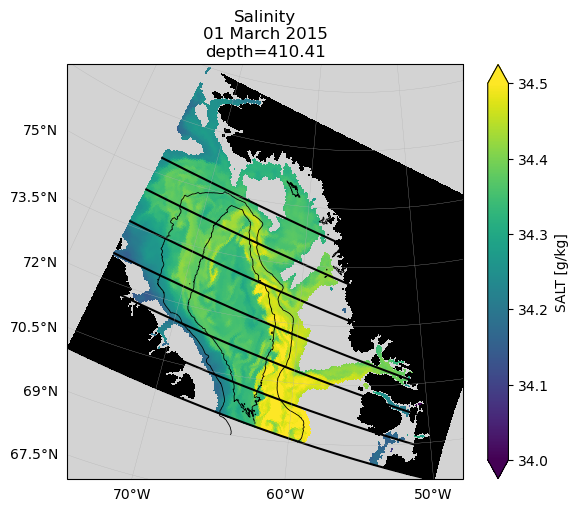

In [106]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

## plot rows over model area
plt.plot(salt_400m_coords.isel(rows=0).longitude, salt_400m_coords.isel(rows=0).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=25).longitude, salt_400m_coords.isel(rows=25).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=50).longitude, salt_400m_coords.isel(rows=50).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=75).longitude, salt_400m_coords.isel(rows=75).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=100).longitude, salt_400m_coords.isel(rows=100).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=125).longitude, salt_400m_coords.isel(rows=125).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=150).longitude, salt_400m_coords.isel(rows=150).latitude, c='k',transform=ccrs.PlateCarree())

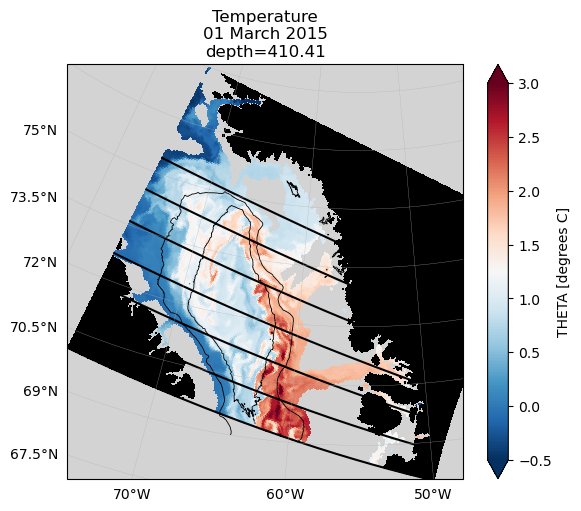

In [59]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

# theta_400m_below = theta_201503_400m.THETA.where(salt_201503_400m.SALT>30,drop=True)
# theta_400m_below.isel(time=0).plot(y='latitude',x='longitude',ax=ax1,transform=ccrs.PlateCarree())

theta_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

## plot rows over model area
plt.plot(salt_400m_coords.isel(rows=0).longitude, salt_400m_coords.isel(rows=0).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=25).longitude, salt_400m_coords.isel(rows=25).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=50).longitude, salt_400m_coords.isel(rows=50).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=75).longitude, salt_400m_coords.isel(rows=75).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=100).longitude, salt_400m_coords.isel(rows=100).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=125).longitude, salt_400m_coords.isel(rows=125).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=150).longitude, salt_400m_coords.isel(rows=150).latitude, c='k',transform=ccrs.PlateCarree())

Plot lines for each box section for AW

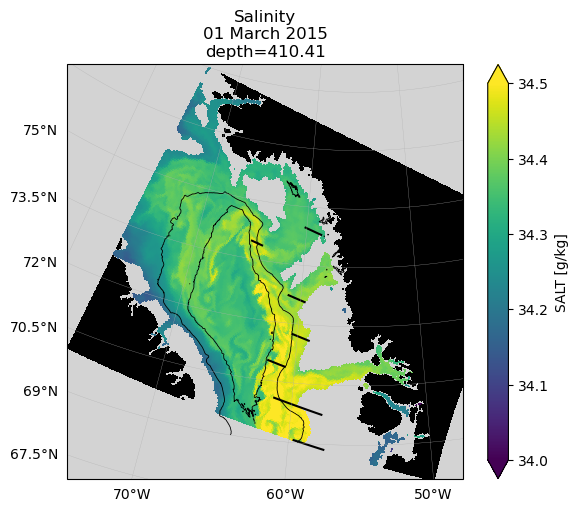

In [107]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

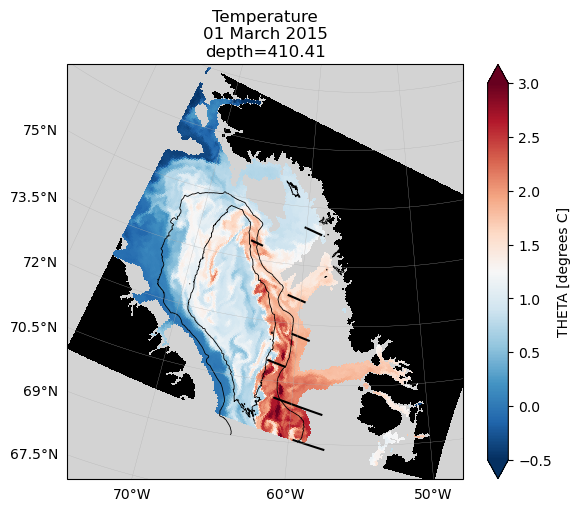

In [108]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

# theta_400m_below = theta_201503_400m.THETA.where(salt_201503_400m.SALT>30,drop=True)
# theta_400m_below.isel(time=0).plot(y='latitude',x='longitude',ax=ax1,transform=ccrs.PlateCarree())

theta_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

## 300 m

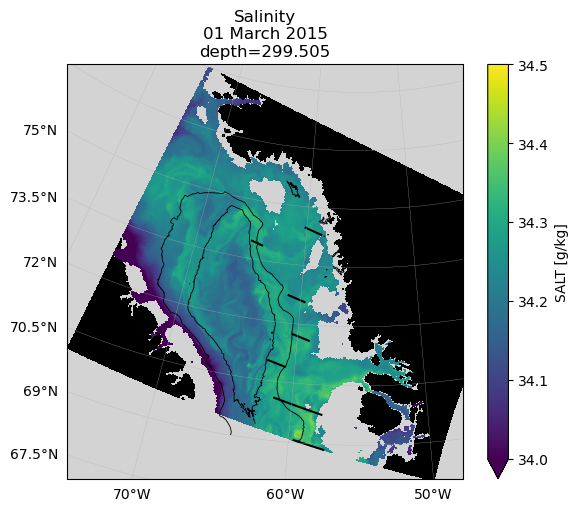

In [109]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_300m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_300m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_300m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

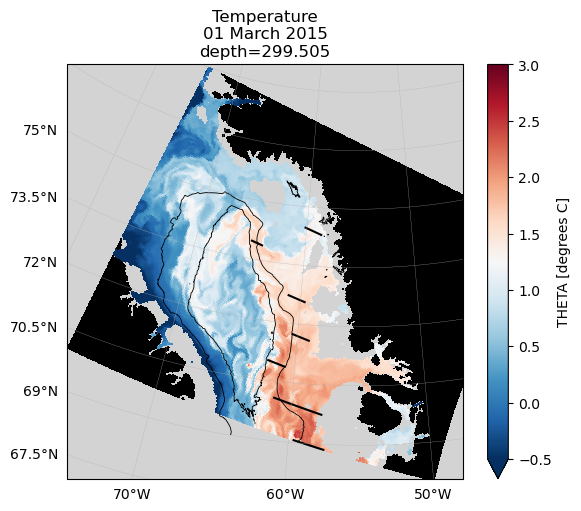

In [110]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

theta_300m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_300m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_300m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

ANOMALY

In [103]:
salt_400m_below_anomaly = (salt_400m_below-salt_400m_below.mean()).load()

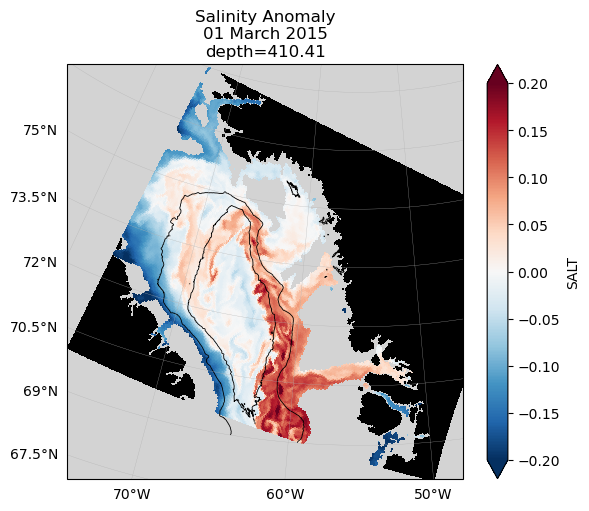

In [86]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below_anomaly.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.2,vmax=0.2,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity Anomaly\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

In [78]:
theta_400m_below_anomaly = (theta_400m_below-theta_400m_below.mean()).load()

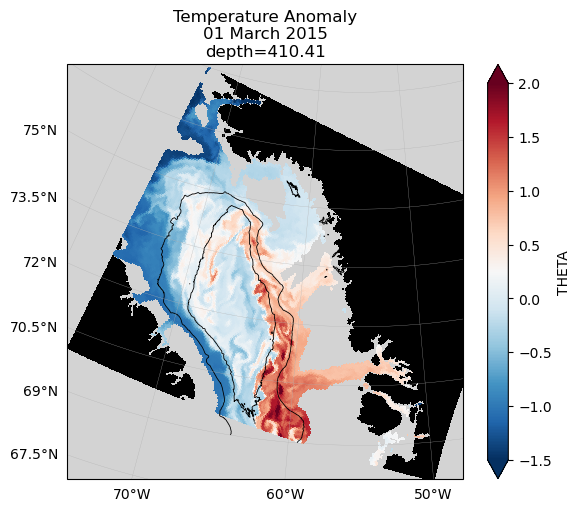

In [87]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

theta_400m_below_anomaly.plot(y='latitude',x='longitude',ax=ax1,vmin=-1.5,vmax=2,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature Anomaly\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

#### Take area-weighted mean

In [ ]:
## first switch latitude and longitude from variables to coordinates
theta_ds = theta_time_ds.set_coords(['latitude','longitude'])
salt_ds = salt_time_ds.set_coords(['latitude','longitude'])

In [ ]:
## select data for the three locations (all depths)

## Ummannaq (referred to as 'south')
south_theta_ds = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).THETA
south_salt_ds  = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).SALT

## Upernavik (referred to as 'center')
center_theta_ds = theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).THETA
center_salt_ds  = salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).SALT

## Melville Bay (referred to as 'north')
north_theta_ds = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).THETA
north_salt_ds  = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).SALT

In [ ]:
south_theta_ds=south_theta_ds.load()

In [ ]:
south_theta_ds[:,0,0].plot()

In [ ]:
## take area weighted mean for each location
## cos(lat) is proportional to grid cell area
weights = np.cos(np.deg2rad(south_theta_ds.isel(time=0).latitude))
weights.name = 'weights_cosine_lat'

In [ ]:
## visualize weights - looks good (weights decrease with increasing latitude)
weights.plot();

In [ ]:
south_theta_mean_weighted = (south_theta_ds*weights).sum(dim=["rows","cols"])/weights.sum()

In [ ]:
# compare weighted and unweighted theta for Ummannaq
south_theta_mean_weighted.sel(depth=250, method='nearest').plot()
theta_time_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250, method='nearest').THETA.mean(['rows','cols']).plot(label='Ummannaq')

In [ ]:
## function to take area-weighted mean
def area_weighted_mean(ds):
    ## take area weighted mean for each location
    ## cos(lat) is proportional to grid cell area
    weights = np.cos(np.deg2rad(ds.isel(time=0).latitude))
    weights.name = 'weights_cosine_lat'
        
    ## take mean
    ds_mean_weighted = (ds*weights).sum(dim=["rows","cols"])/weights.sum()
    
    return ds_mean_weighted

In [ ]:
## take area-weighted mean for three locations

## Ummannaq (referred to as 'south')
south_theta_mean_weighted = area_weighted_mean(south_theta_ds)
south_salt_mean_weighted  = area_weighted_mean(south_salt_ds)

## Upernavik (referred to as 'center')
center_theta_mean_weighted = area_weighted_mean(center_theta_ds)
center_salt_mean_weighted  = area_weighted_mean(center_salt_ds)

## Melville Bay (referred to as 'north')
north_theta_mean_weighted = area_weighted_mean(north_theta_ds)
north_salt_mean_weighted  = area_weighted_mean(north_salt_ds)